###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D SH finite difference modelling - the quarter plane problem

Before modelling the propagation of Love-waves, let's take a look how accurate reflected body waves from the free-surface boundary can be modelled using the quarter plane problem. This is an important aspect, because one way to understand Love waves is by the interference of SH-body waves in a layered medium.

## Analytical solution of 2D SH quarter plane problem

We seek an analytical solution to the 2D isotropic elastic SH problem: 

\begin{align}
\rho \frac{\partial v_y}{\partial t} &= \frac{\partial \sigma_{yx}}{\partial x} + \frac{\partial \sigma_{yz}}{\partial z} + f_y, \notag\\
\frac{\partial \sigma_{yx}}{\partial t} &= \mu \frac{\partial v_{y}}{\partial x},\notag\\
\frac{\partial \sigma_{yz}}{\partial t} &= \mu \frac{\partial v_{y}}{\partial z}. \notag\\
\end{align}

for wave propagation in a homogeneous medium, by setting density $\rho$ and shear modulus $\mu$ to constant values $\rho_0,\; \mu_0$

\begin{align}
\rho(i,j) &= \rho_0 \notag \\
\mu(i,j) &= \mu_0 = \rho_0 V_{s0}^2\notag
\end{align}

at each spatial grid point $i = 0, 1, 2, ..., nx$; $j = 0, 1, 2, ..., nz$, in order to compare the numerical with the analytical solution. For a complete description of the problem we also have to define initial and boundary conditions. The **initial condition** is 

\begin{equation}
v_y(i,j,0) = \sigma_{yx}(i+1/2,j,0) = \sigma_{yz}(i,j+1/2,0) = 0, \nonumber
\end{equation}

so the modelling starts with zero particel velocity and shear stress amplitudes at each spatial grid point. As **boundary conditions**, we assume 

\begin{align}
v_y(0,j,n) &= \sigma_{yx}(1/2,j,n) = \sigma_{yz}(0,j+1/2,n) = 0, \nonumber\\
v_y(nx,j,n) &= \sigma_{yx}(nx+1/2,j,n) = \sigma_{yz}(nx,j+1/2,n) = 0, \nonumber\\
v_y(i,0,n) &= \sigma_{yx}(i+1/2,0,n) = \sigma_{yz}(i,1/2,n) = 0, \nonumber\\
v_y(i,nz,n) &= \sigma_{yx}(i+1/2,nz,n) = \sigma_{yz}(i,nz+1/2,n) = 0, \nonumber\\
\end{align}

for all time steps n. This **Dirichlet boundary condition**, leads to artifical boundary reflections. In the [previous notebook](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/06_2D_SH_Love_wave_modelling/2_From_2D_acoustic_to_SH_FD_modelling_final.ipynb), we neglected these reflections. In this case, we want to incorporate them into the analytical solution, to test how accurate the boundary reflections actually are. We can describe the reflections by using **image points**

<img src="images/SH_quarter_problem.jpg" width="60%">

where we excitate the Green's function solution for the homogenous medium:

\begin{equation}
G_{2D}(x,z,t,xsrc,zsrc) = \dfrac{1}{2\pi \rho_0 V_{s0}^2}\dfrac{H\biggl((t-t_s)-\dfrac{|r|}{V_{s0}}\biggr)}{\sqrt{(t-t_s)^2-\dfrac{r^2}{V_{s0}^2}}}, \nonumber 
\end{equation}

where $H$ denotes the Heaviside function, $r = \sqrt{(x-x_s)^2+(z-z_s)^2}$ the source-receiver distance (offset), at image point ... 

- 1 (-xsrc, zsrc) to describe the reflection from the left free surface boundary
- 2 (-xsrc, -zsrc) to describe the reflection from the lower left corner
- 3 (xsrc, -zsrc) to describe the reflection from the bottom free surface boundary

Using the **superposition principle** of linear partial differential equations, we can describe the Green's function solution for the source and reflected wavefield by

\begin{align}
G_{2D}^{total}(x,z,t,xsrc,zsrc) &= G_{2D}^{source}(x,z,t,xsrc,zsrc) + G_{2D}^{image1}(x,z,t,-xsrc,zsrc)\nonumber\\  
&+ G_{2D}^{image2}(x,z,t,-xsrc,-zsrc) + G_{2D}^{image3}(x,z,t,xsrc,-zsrc)\nonumber\\
\end{align}

For a given source wavelet S, we get the displacement wavefield:

\begin{equation}
u_{y,analy}^{total}(x,z,t) = G_{2D}^{total} * S \nonumber 
\end{equation}

Keep in mind that the stress-velocity code computes the **particle velocities** $\mathbf{v_{y,analy}^{total}}$, while the analytical solution is expressed in terms of the **displacement** $\mathbf{u_{y,analy}^{total}}$. Therefore, we have to take the first derivative of the analytical solution, before comparing the numerical with the analytical solution:

\begin{equation}
v_{y,analy}^{total}(x,z,t) = \frac{\partial u_{y,analy}^{total}}{\partial t} \nonumber 
\end{equation}

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------
xmax = 500.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax  # maximum spatial extension of the 1D model in z-direction(m)

tmax = 1.12   # maximum recording time of the seismogram (s)

vs0  = 580.   # S-wave speed in medium (m/s)
rho0 = 1000.  # Density in medium (kg/m^3)

# acquisition geometry
xr = 125.0 # x-receiver position (m)
zr = xr    # z-receiver position (m)

xsrc = 250.0 # x-source position (m)
zsrc = xsrc  # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

To build the FD code, we first define the velocity update $v_y$ ...

In [4]:
# Particle velocity vy update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho, op):
    
    # 2nd order FD operator
    if (op==2):   
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
            
                # Calculate spatial derivatives  (2nd order operator)           
                syx_x = (syx[i,j] - syx[i - 1,j]) / dx
                syz_z = (syz[i,j] - syz[i,j - 1]) / dz
            
                # Update particle velocities
                vy[i,j] = vy[i,j] + (dt/rho[i,j]) * (syx_x + syz_z)                               
                
    return vy

... update the shear stress components $\sigma_{yx}$ and $\sigma_{yz}$ ...

In [5]:
# Shear stress syx, syz updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz, op):
    
    # 2nd order FD operator
    if(op==2):
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
            
                # Calculate spatial derivatives (2nd order operator)
                vy_x = (vy[i + 1,j] - vy[i,j]) / dx
                vy_z = (vy[i,j + 1] - vy[i,j]) / dz
            
                # Update shear stresses
                syx[i,j] = syx[i,j] + dt * mux[i,j] * vy_x
                syz[i,j] = syz[i,j] + dt * muz[i,j] * vy_z                    
    
    return syx, syz

... and harmonically averaging the shear modulus ...

In [6]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nx, nz, mux, muz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate harmonic averages of shear moduli        
            mux[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])
            muz[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
            
    return mux, muz

Finally, we define a function to calculate the Green's function at arbritary source positions or image points ...

In [7]:
def Green_2D(ir, jr, xsrc, zsrc, x, z, vs0, rho0, time, G, nt):
    
    # calculate source-receiver distance
    #r = np.sqrt((x[ir] - x[isrc])**2 + (z[jr] - z[jsrc])**2)
    r = np.sqrt((x[ir] - xsrc)**2 + (z[jr] - zsrc)**2)
    
    for it in range(nt): # Calculate Green's function (Heaviside function)
        if (time[it] - r / vs0) >= 0:
            G[it] = 1. / (2 * np.pi * rho0 * vs0**2) * (1. / np.sqrt(time[it]**2 - (r/vs0)**2))
    
    return G

... and assemble the 2D SH FD code ...

In [8]:
# 2D SH Wave Propagation (Finite Difference Solution) 
# ---------------------------------------------------
def FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,op):
        
    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)
    
    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction
    
    # half FD-operator length
    noph = (int)(op/2)

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # Analytical solution
    # -------------------
    G        = time * 0.
    G1       = time * 0.
    G2       = time * 0.
    G3       = time * 0.
    vy_analy = time * 0.

    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)
    
    # calculate 2D Green's function for direct SH wave from source position    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction
    
    # calculate source position from isrc and jsrc
    xsrcd = isrc * dx
    zsrcd = jsrc * dz
    
    G = Green_2D(ir, jr, xsrcd, zsrcd, x, z, vs0, rho0, time, G, nt)
    
    # calculate 2D Green's function for image points
    # shift image points by half the FD operator size to compare with FD solution
    G1 = Green_2D(ir, jr, -xsrcd + noph*dx, zsrcd, x, z, vs0, rho0, time, G1, nt)
    G2 = Green_2D(ir, jr, xsrcd, -zsrcd+noph*dz, x, z, vs0, rho0, time, G2, nt)
    G3 = Green_2D(ir, jr, -xsrcd+noph*dx, -zsrcd+noph*dz, x, z, vs0, rho0, time, G3, nt)
    
    G = G + G1 + G2 + G3 
    
    Gc   = np.convolve(G, src * dt)
    Gc   = Gc[0:nt]
    
    # compute vy_analy from uy_analy
    for i in range(1, nt - 1):
        vy_analy[i] = (Gc[i+1] - Gc[i-1]) / (2.0 * dt)           
    
    # Initialize empty pressure arrays
    # --------------------------------
    vy    = np.zeros((nx,nz)) # particle velocity vy
    syx   = np.zeros((nx,nz)) # shear stress syx
    syz   = np.zeros((nx,nz)) # shear stress syz        

    # Initialize model (assume homogeneous model)
    # -------------------------------------------    
    vs    = np.zeros((nx,nz))
    vs    = vs + vs0      # initialize wave velocity in model
    
    rho   = np.zeros((nx,nz))
    rho   = rho + rho0    # initialize wave velocity in model
    
    # calculate shear modulus
    mu    = np.zeros((nx,nz))
    mu    = rho * vs ** 2 
    
    # harmonic average of shear moduli
    # --------------------------------
    mux   = mu # initialize harmonic average mux 
    muz   = mu # initialize harmonic average muz

    mux, muz = shear_avg(mu, nx, nz, mux, muz)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt)     
    
    # Time looping
    # ------------
    for it in range(nt):
    
        # Update particle velocity vy
        # ---------------------------
        vy = update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho, op)

        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vy[isrc,jsrc] = vy[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dx * dz))
        
        # Update shear stress syx, syz
        # ----------------------------
        syx, syz = update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz, op)                
                           
        # Output of Seismogram
        # -----------------
        seis[it] = vy[ir,jr]   
        
    # Compare FD Seismogram with analytical solution
    # ---------------------------------------------- 
    # Define figure size
    rcParams['figure.figsize'] = 12, 5
    plt.plot(time, seis, 'b-',lw=3,label="FD solution") # plot FD seismogram
    Analy_seis = plt.plot(time,vy_analy,'r--',lw=3,label="Analytical solution") # plot analytical solution
    plt.xlim(time[0], time[-1])
    plt.title('Seismogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()     
    
    return vy

First, we compare the analytical solution with the FD modelling result using the spatial 2nd order operator and a wavefield sampling of $N_\lambda = 12$ gridpoints per minimum wavelength:

nx =  827
nz =  827
nt =  1520


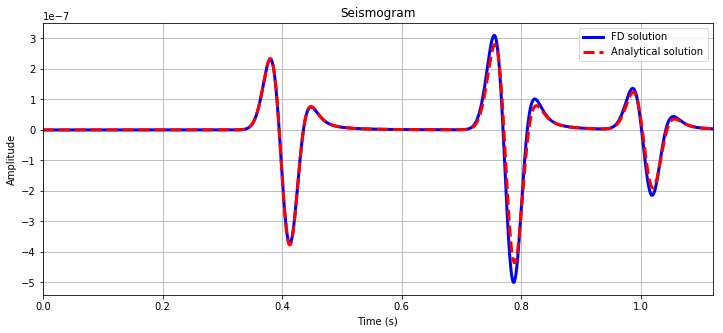

In [9]:
Nlam = 12
dx = vs0 / (Nlam * 2 * f0)
dz   = dx    # grid point distance in z-direction (m)

op = 2       # order of spatial FD operator

# calculate dt according to CFL criterion
dt = dx / (np.sqrt(2) * vs0) 

vy = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,op)

While, the direct SH wave is modelled very accurately, the fit of the boundary reflection waveforms can be improved. Let's try more grid points per minimum wavelength ($N_\lambda = 16$)...

nx =  1103
nz =  1103
nt =  2027


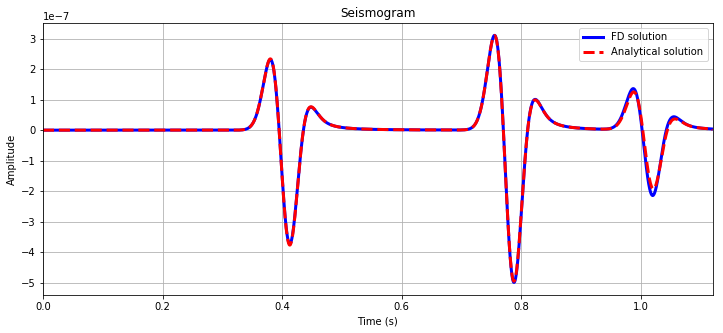

In [10]:
Nlam = 16
dx = vs0 / (Nlam * 2 * f0)
dz   = dx    # grid point distance in z-direction (m)

op = 2       # order of spatial FD operator

# calculate dt according to CFL criterion
dt = dx / (np.sqrt(2) * vs0) 

vy = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,op)

... which leads to an improved waveform fit of the boundary reflections.

## What we learned:

* Estimating an analytical solution to the quarter-plane problem using the image method and superposition principle of linear partial differential equations
* To accurately model the boundary reflections, we have to use at least $N_\lambda = 16$ gridpoints per wavelength for the 2nd order FD operator.